<a href="https://colab.research.google.com/github/AnLiMan/CAN-interpret-For-J1939/blob/main/CAN_decoder_v_0.1.3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Описание

Текст



In [16]:
csv_file = 'https://raw.githubusercontent.com/AnLiMan/CAN-interpret-For-J1939/main/Logs/Data_5.csv'
df = pd.read_csv(csv_file) # Прочтём датасет
df.head() # Выведем заголовок

/usr/local/lib/python3.11/dist-packages/google/colab/_dataframe_summarizer.py:88: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cast_date_col = pd.to_datetime(column, errors="coerce")


,Time,Unnamed: 1,ID (hex),Data (hex)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN


# Настройки

In [25]:
csv_file = 'https://raw.githubusercontent.com/AnLiMan/CAN-interpret-For-J1939/main/Logs/Data_7.csv'

# Библиотеки

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import time

#Обработка данных

/tmp/ipython-input-34-710940931.py:3: ParserWarning: Skipping line 8372: expected 8 fields, saw 9
Skipping line 9035: expected 8 fields, saw 9
Skipping line 9042: expected 8 fields, saw 9
Skipping line 9179: expected 8 fields, saw 9
Skipping line 9463: expected 8 fields, saw 9
Skipping line 9714: expected 8 fields, saw 9
Skipping line 9887: expected 8 fields, saw 9
Skipping line 10050: expected 8 fields, saw 9
Skipping line 10413: expected 8 fields, saw 9
Skipping line 10420: expected 8 fields, saw 9
Skipping line 10428: expected 8 fields, saw 9
Skipping line 10436: expected 8 fields, saw 9
Skipping line 10440: expected 8 fields, saw 9

  df = pd.read_csv(csv_file, on_bad_lines='warn')  # Пропускает проблемные строки с предупреждением



Статистика по данным:
Всего строк: 11919
Уникальных CAN ID: 23

Топ-5 частых CAN ID:
ID (hex)
18FF0104    1759
18FFF504    1757
18FEF704    1756
CFDD780     1296
CFDD680     1295
Name: count, dtype: int64


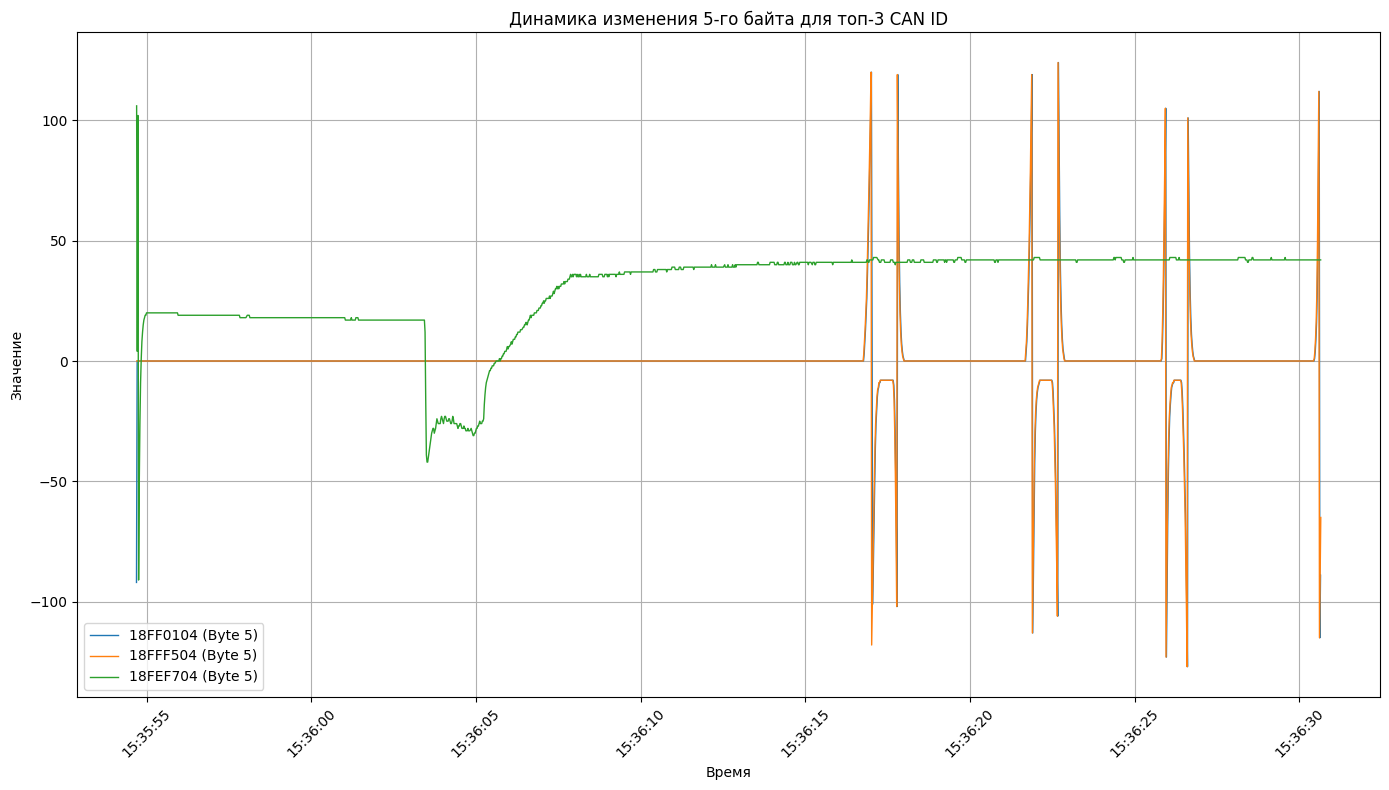

In [34]:
try:
    # Пытаемся прочитать файл стандартным способом
    df = pd.read_csv(csv_file, on_bad_lines='warn')  # Пропускает проблемные строки с предупреждением
except pd.errors.ParserError:
    # Если возникает ошибка, читаем файл построчно с обработкой ошибок
    print("Обнаружены проблемы в формате данных, применяем обработку строк...")

    # Альтернативный метод чтения с обработкой ошибок
    with pd.compat.urlopen(csv_file) as response:
        content = response.read().decode('utf-8')

    # Читаем строки, пропуская проблемные
    lines = []
    for line in StringIO(content).readlines():
        try:
            pd.read_csv(StringIO(line), header=None)
            lines.append(line)
        except pd.errors.ParserError:
            print(f"Пропущена строка из-за ошибки формата: {line[:100]}...")
            continue

    # Собираем корректные строки в DataFrame
    df = pd.read_csv(StringIO(''.join(lines)))

# Выбираем только нужные столбцы и фильтруем Remote Frame
try:
    df = df[['Time', 'ID (hex)', 'Data (hex)']].copy()
    df = df[~df['Data (hex)'].astype(str).str.contains('Remote Frame', na=False)]
except KeyError as e:
    print(f"Ошибка: в данных отсутствует необходимый столбец {e}")
    print("Доступные столбцы:", df.columns.tolist())
    exit()

# Функции для обработки данных (остаются без изменений)
def clean_hex(hex_str):
    """Очистка HEX-строки"""
    if pd.isna(hex_str) or 'Remote' in str(hex_str):
        return None
    return hex_str.strip()

def parse_j1939_id(can_id_hex):
    """Разбор CAN ID по протоколу J1939"""
    try:
        can_id = int(str(can_id_hex).strip(), 16)
        priority = (can_id >> 26) & 0x7
        pdu_format = (can_id >> 16) & 0xFF
        source_address = can_id & 0xFF

        return {
            'priority': priority,
            'pdu_format': pdu_format,
            'source_address': source_address,
            'can_id_full': can_id
        }
    except:
        return None

def hex_to_signed(hex_str):
    """Преобразование HEX в знаковое целое с обработкой ошибок"""
    try:
        if not isinstance(hex_str, str) or len(hex_str.strip()) == 0:
            return None
        num = int(hex_str.strip(), 16)
        return num - 256 if num > 127 else num
    except:
        return None

def parse_can_data(data_hex):
    """Разбор данных CAN с обработкой ошибок"""
    try:
        if pd.isna(data_hex):
            return {f'byte_{i}': None for i in range(1, 9)}

        bytes_list = str(data_hex).strip().split()
        return {f'byte_{i}': hex_to_signed(byte) for i, byte in enumerate(bytes_list, 1) if i <= 8}
    except:
        return {f'byte_{i}': None for i in range(1, 9)}

# Применяем функции очистки
df['ID (hex)'] = df['ID (hex)'].apply(clean_hex)
df['Data (hex)'] = df['Data (hex)'].apply(clean_hex)

# Удаляем строки с пустыми данными
df = df.dropna(subset=['ID (hex)', 'Data (hex)'])

# Парсим ID и данные с обработкой ошибок
try:
    j1939_data = df['ID (hex)'].apply(parse_j1939_id).apply(pd.Series)
    can_data = df['Data (hex)'].apply(parse_can_data).apply(pd.Series)

    # Объединяем всё в один DataFrame
    df = pd.concat([df, j1939_data, can_data], axis=1)
except Exception as e:
    print(f"Ошибка при обработке данных: {e}")
    exit()

# Преобразуем время с обработкой ошибок
try:
    df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S.%f', errors='coerce')
    df = df.dropna(subset=['Time'])  # Удаляем строки с некорректным временем
except Exception as e:
    print(f"Ошибка при обработке времени: {e}")

# Анализ данных
print("\nСтатистика по данным:")
print(f"Всего строк: {len(df)}")
print(f"Уникальных CAN ID: {df['ID (hex)'].nunique()}")
print("\nТоп-5 частых CAN ID:")
print(df['ID (hex)'].value_counts().head(5))

# Визуализация (только если есть данные)
if not df.empty:
    plt.figure(figsize=(14, 8))
    top_ids = df['ID (hex)'].value_counts().index[:3]

    for can_id in top_ids:
        subset = df[df['ID (hex)'] == can_id]
        if not subset.empty and 'byte_5' in subset.columns:
            plt.plot(subset['Time'], subset['byte_5'],

                    label=f'{can_id} (Byte 5)', linewidth=1)

    plt.title('Динамика изменения 5-го байта для топ-3 CAN ID')
    plt.xlabel('Время')
    plt.ylabel('Значение')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("Нет данных для визуализации")

In [38]:
def get_unique_can_ids(df, id_column='ID (hex)'):
    """
    Возвращает отсортированный массив уникальных CAN ID из датасета

    Параметры:
        df (pd.DataFrame): Датафрейм с CAN-логами
        id_column (str): Название столбца с CAN ID (по умолчанию 'ID (hex)')

    Возвращает:
        np.ndarray: Отсортированный массив уникальных ID
    """
    try:
        # Проверяем наличие столбца
        if id_column not in df.columns:
            raise KeyError(f"Столбец '{id_column}' не найден в датафрейме")

        # Получаем уникальные ID, удаляем NaN/None, сортируем
        unique_ids = df[id_column].dropna().unique()
        unique_ids = np.sort(unique_ids)

        return unique_ids

    except Exception as e:
        print(f"Ошибка при получении уникальных ID: {e}")
        return np.array([])

# Пример использования
unique_ids = get_unique_can_ids(df)
print("Найдены уникальные CAN ID:")
print(unique_ids)

Найдены уникальные CAN ID:
['18EA0017' '18EEFF17' '18F00400' '18FD0700' '18FECA00' '18FECA03'
 '18FEE400' '18FEE500' '18FEE900' '18FEEE00' '18FEEF00' '18FEF500'
 '18FEF700' '18FEF704' '18FEF803' '18FEFF00' '18FF0104' '18FFF003'
 '18FFF103' '18FFF403' '18FFF504' 'CFDD680' 'CFDD780']


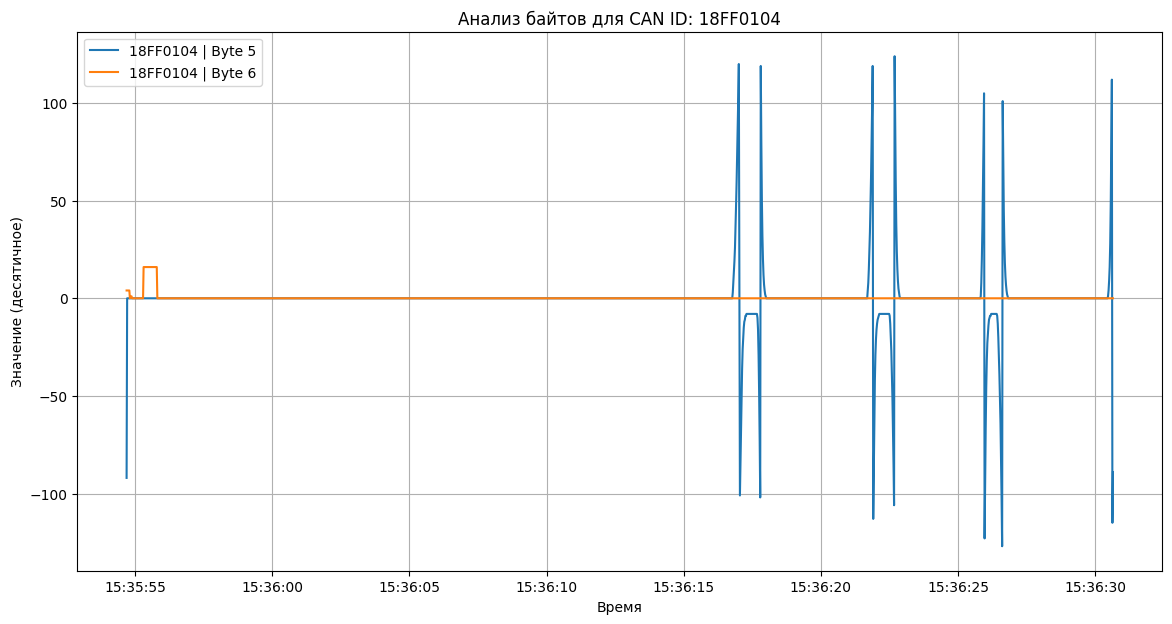

In [33]:
# Выбираем CAN ID и байты для анализа
target_id = '18FF0104'  # Пример ID, где 5-й байт меняется
bytes_to_plot = [5, 6]  # Анализируем 5-й и 6-й байты

# Фильтруем данные по выбранному CAN ID
subset = df[df['ID (hex)'] == target_id]

if not subset.empty:
    plt.figure(figsize=(14, 7))

    for byte in bytes_to_plot:
        byte_col = f'byte_{byte}'
        if byte_col in subset.columns:
            plt.plot(subset['Time'], subset[byte_col],
                    marker='', linestyle='-',
                    label=f'{target_id} | Byte {byte}')

    plt.title(f'Анализ байтов для CAN ID: {target_id}')
    plt.xlabel('Время')
    plt.ylabel('Значение (десятичное)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Данные для CAN ID {target_id} не найдены")

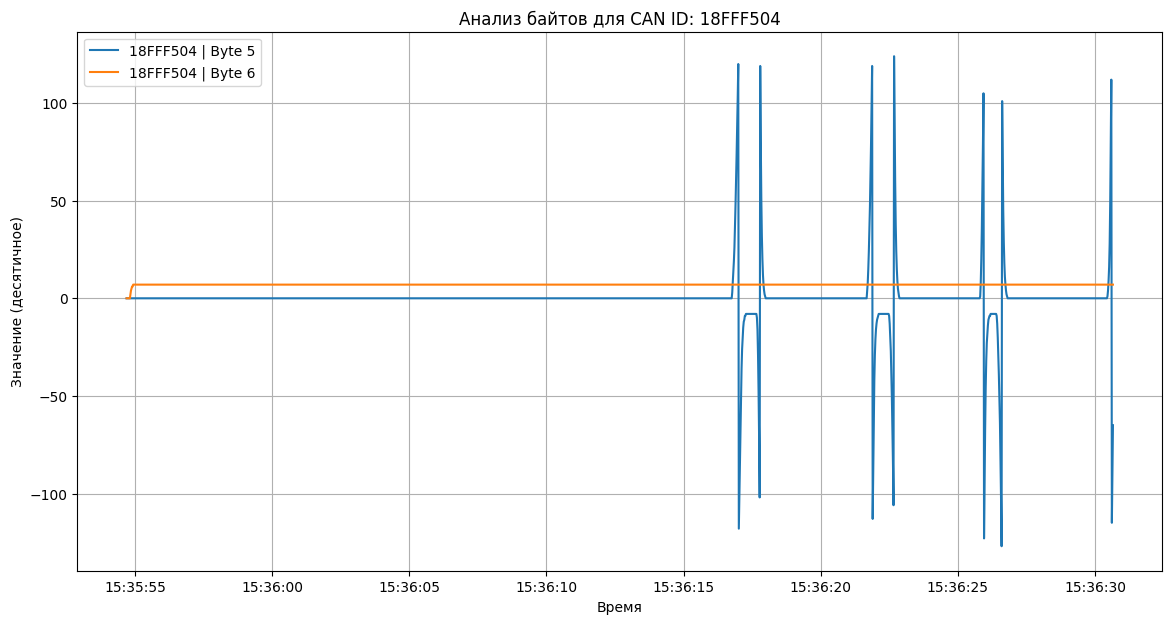

In [35]:
# Выбираем CAN ID и байты для анализа
target_id = '18FFF504'  # Пример ID, где 5-й байт меняется
bytes_to_plot = [5, 6]  # Анализируем 5-й и 6-й байты

# Фильтруем данные по выбранному CAN ID
subset = df[df['ID (hex)'] == target_id]

if not subset.empty:
    plt.figure(figsize=(14, 7))

    for byte in bytes_to_plot:
        byte_col = f'byte_{byte}'
        if byte_col in subset.columns:
            plt.plot(subset['Time'], subset[byte_col],
                    marker='', linestyle='-',
                    label=f'{target_id} | Byte {byte}')

    plt.title(f'Анализ байтов для CAN ID: {target_id}')
    plt.xlabel('Время')
    plt.ylabel('Значение (десятичное)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Данные для CAN ID {target_id} не найдены")

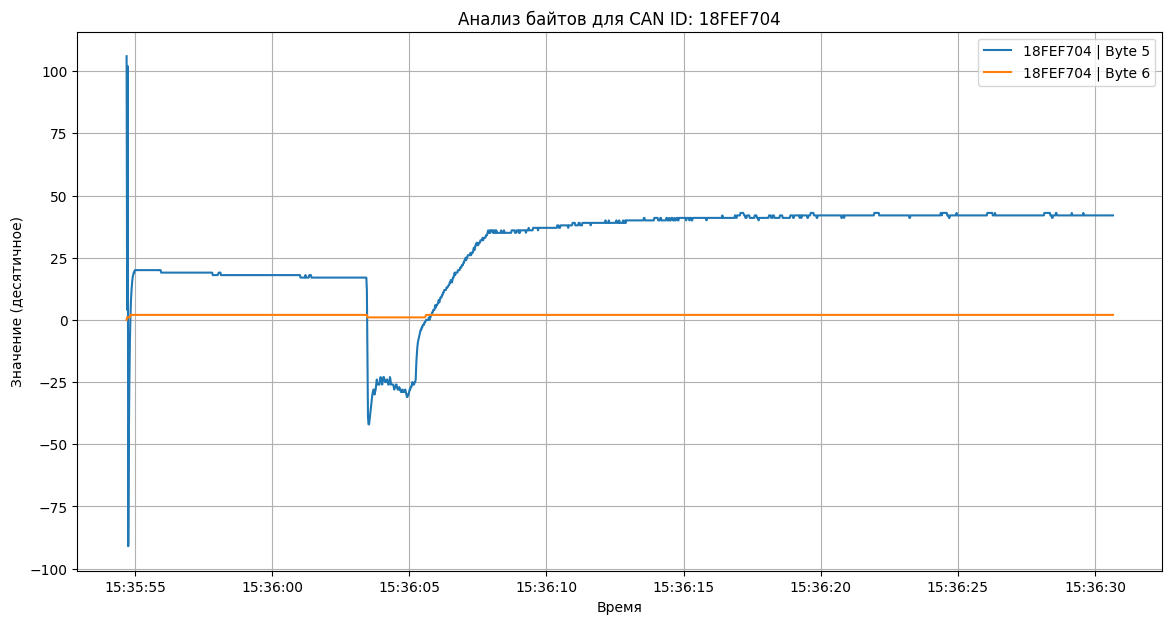

In [36]:
# Выбираем CAN ID и байты для анализа
target_id = '18FEF704'  # Пример ID, где 5-й байт меняется
bytes_to_plot = [5, 6]  # Анализируем 5-й и 6-й байты

# Фильтруем данные по выбранному CAN ID
subset = df[df['ID (hex)'] == target_id]

if not subset.empty:
    plt.figure(figsize=(14, 7))

    for byte in bytes_to_plot:
        byte_col = f'byte_{byte}'
        if byte_col in subset.columns:
            plt.plot(subset['Time'], subset[byte_col],
                    marker='', linestyle='-',
                    label=f'{target_id} | Byte {byte}')

    plt.title(f'Анализ байтов для CAN ID: {target_id}')
    plt.xlabel('Время')
    plt.ylabel('Значение (десятичное)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Данные для CAN ID {target_id} не найдены")

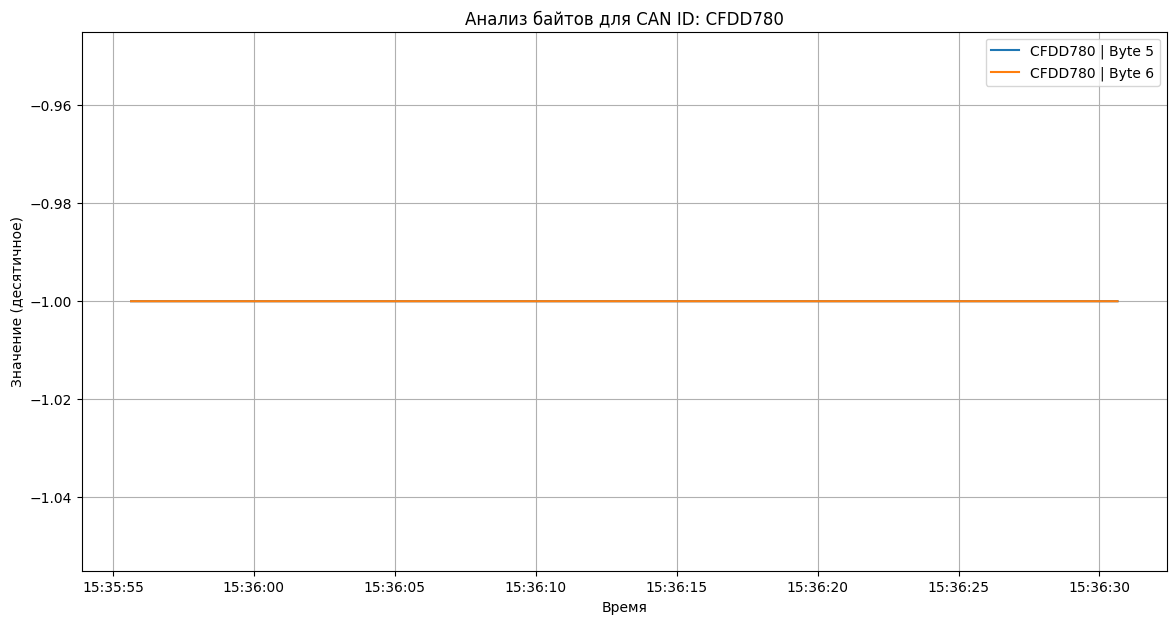

In [37]:
# Выбираем CAN ID и байты для анализа
target_id = 'CFDD780'  # Пример ID, где 5-й байт меняется
bytes_to_plot = [5, 6]  # Анализируем 5-й и 6-й байты

# Фильтруем данные по выбранному CAN ID
subset = df[df['ID (hex)'] == target_id]

if not subset.empty:
    plt.figure(figsize=(14, 7))

    for byte in bytes_to_plot:
        byte_col = f'byte_{byte}'
        if byte_col in subset.columns:
            plt.plot(subset['Time'], subset[byte_col],
                    marker='', linestyle='-',
                    label=f'{target_id} | Byte {byte}')

    plt.title(f'Анализ байтов для CAN ID: {target_id}')
    plt.xlabel('Время')
    plt.ylabel('Значение (десятичное)')
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print(f"Данные для CAN ID {target_id} не найдены")